In [63]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

In [75]:
# バッチサイズ
m = 50

# 潜在変数の次元数
n_z = 2

n_epoch = 10

In [76]:
# Q(z|X) -- encoder
inputs = Input(shape=(784, ))
h_q = Dense(512, activation='relu')(inputs)

# 中間層のh_qからmuとsigmaを生成
# zは N(mu, sigma) からサンプリングされる
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

In [77]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0.0, stddev=1.0)
    return mu + K.exp(log_sigma / 2) * eps

In [78]:
sample_z((0, 1))

<tf.Tensor 'add_69:0' shape=(50, 2) dtype=float32>

In [79]:
# encoderの出力 [mu, log_sigma] を使ってサンプリング
# m個のサンプルzが得られる
# sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

In [80]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [81]:
outputs

<tf.Tensor 'dense_12/Sigmoid:0' shape=(50, 784) dtype=float32>

In [82]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, representative of Gaussian
encoder = Model(inputs, mu)

In [83]:
# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z, ))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [84]:
def vae_loss(y_true, y_pred):
    # E[log P(X|z)] => max  <=>  zから生成されたXと元のXの誤差が小さい
    # axis=1はBatch方向に和をとる
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|x) || P(z)) => min  <=> 小さくしたいのでそのままlossとする
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1.0 - log_sigma, axis=1)
    return recon + kl

In [85]:
vae.compile(optimizer='adam', loss=vae_loss)

In [86]:
vae

In [87]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [88]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [39]:
X_train.shape

(60000, 28, 28)

In [90]:
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

In [91]:
X_train.shape

(60000, 784)

In [97]:
vae.fit(X_train, X_train, batch_size=m, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 17s - loss: 156.5659    
Epoch 2/5
60000/60000 [==============================] - 16s - loss: 155.5695    
Epoch 3/5
60000/60000 [==============================] - 15s - loss: 154.8109    
Epoch 4/5
60000/60000 [==============================] - 15s - loss: 154.1780    
Epoch 5/5
60000/60000 [==============================] - 15s - loss: 153.5644    


In [98]:
z_test = encoder.predict(X_test)

In [99]:
z_test.shape

(10000, 2)

In [100]:
y_test.shape

(10000,)

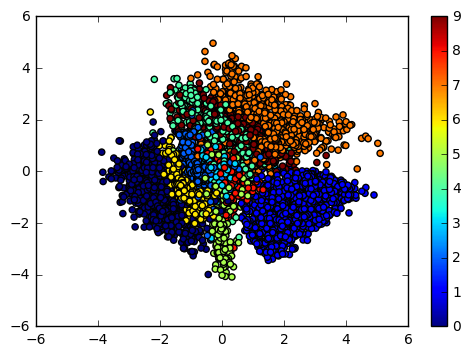

In [101]:
plt.figure()
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test)
plt.colorbar()

In [103]:
z = np.random.normal(size=100)

In [105]:
z = z.reshape((50, 2))

In [106]:
z.shape

(50, 2)

In [107]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             multiple                  1536      
_________________________________________________________________
dense_12 (Dense)             multiple                  402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [110]:
x = decoder.predict(z)

In [111]:
x.shape

(50, 784)

In [112]:
x = x.reshape(-1, 28, 28)

In [113]:
x.shape

(50, 28, 28)

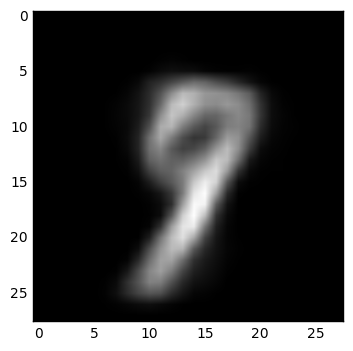

In [122]:
plt.imshow(x[0], cmap='gray')